In [1]:
import os
import torch
import numpy as np
import SimpleITK as sitk
import nibabel as nib
import scipy.ndimage
from torchvision import transforms
import napari
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt
import random
import time

In [2]:

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### Кастмоный датасет, который можно использовать, чтобы просматривать исходные данные

In [ ]:
# #Датасет для загрузки DICOM файла целиком
# class DICOM_seg(Dataset):
#     def __init__(self, image_dir, mask_dir, transform=None):
#         self.image_dir = image_dir
#         self.mask_dir = mask_dir
#         self.transform = transform
#         self.images = os.listdir(image_dir)
        
#     def __len__(self):
#         return len(self.images)
    
#     @staticmethod
#     def load_dicom(directory):
#         reader = sitk.ImageSeriesReader()
#         dicom_names = reader.GetGDCMSeriesFileNames(directory)
#         reader.SetFileNames(dicom_names)
#         image_itk = reader.Execute()
#         image_zyx = sitk.GetArrayFromImage(image_itk).astype(np.int16)
#         return image_zyx
    
#     @staticmethod
#     def make_path_right(path):
#         path = path.replace('\\','/')
#         return path
    
#     def __getitem__(self, idx):
#         # загрузка изображений и масок
#         img_path = os.path.join(self.image_dir, self.images[idx])
#         img_path = self.make_path_right(img_path)
#         mask_path = os.path.join(self.mask_dir, self.images[idx])
#         mask_path = os.path.join(mask_path, os.listdir(mask_path)[0])
#         mask_path = self.make_path_right(mask_path)

#         image = self.load_dicom(img_path)
        
#         mask = nib.load(mask_path).get_fdata().transpose(2,0,1)
#         mask = scipy.ndimage.rotate(mask, 90,(1,2)).astype(np.float32)
        
#         if self.transform:
#             image, mask = self.transform(image, mask)
            
#         mask_tensor = torch.from_numpy(mask.astype(int)).unsqueeze(0) 
        

#         image_tensor = torch.from_numpy(image).unsqueeze(0)

#         return image_tensor, mask_tensor

In [ ]:

# train = DICOM_seg('./subset','./subset_masks')

In [ ]:
# pic = train.__getitem__(9)

In [ ]:
# pic[1].shape

In [ ]:
# image = pic[0].squeeze(0).numpy()
# mask = pic[1].squeeze(0).numpy()

##### Библиотека для визуализации данных

In [ ]:
# viewer = napari.Viewer()
# viewer.add_image(image, name='DICOM')
# viewer.add_labels(mask, name='Mask')

### Датасет для загрузки DICOM файла послойно и их аугментация

### Датасет с MinMaxScaler

In [3]:
from sklearn.preprocessing import MinMaxScaler

In [4]:
# формат данных для пердачи в кастомный датасет:
# subset-папки с dicom файлами
# subset-masks-папки с файлами .nii.gz


class DICOM_seg(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_layers = []
        self.mask_layers = []
        self.images = os.listdir(image_dir)
        for image_file in self.images:
            img_path = os.path.join(self.image_dir, image_file)
            img_path = self.make_path_right(img_path)
            mask_path = os.path.join(self.mask_dir, image_file)
            mask_path = os.path.join(mask_path, os.listdir(mask_path)[0])
            mask_path = self.make_path_right(mask_path)

            image = self.load_dicom(img_path)
            self.image_layers.extend(image)
            
            mask = nib.load(mask_path).get_fdata().transpose(2,0,1)
            mask = scipy.ndimage.rotate(mask, 90,(1,2)).astype(np.float32)
            self.mask_layers.extend(mask)
        
        # find indices of images with non-zero masks
        self.nonzero_mask_indices = []
        for i, mask_layer in enumerate(self.mask_layers):
            if np.any(mask_layer != 0):
                self.nonzero_mask_indices.append(i)
                
                
    def __len__(self):
#         return len(self.image_layers)
        return len(self.nonzero_mask_indices)
    
    @staticmethod
    def load_dicom(directory):
        reader = sitk.ImageSeriesReader()
        dicom_names = reader.GetGDCMSeriesFileNames(directory)
        reader.SetFileNames(dicom_names)
        image_itk = reader.Execute()
        image_zyx = sitk.GetArrayFromImage(image_itk).astype(np.int16)
        return image_zyx
    
    @staticmethod
    def make_path_right(path):
        path = path.replace('\\','/')
        return path
   # функция для аугментации сегментационного датасета была сделана, так как всего было 10 файлов в среднем со 100 слоями 
    def apply_transform(self, image, mask):
        
        # Transform to tensor
        image = transforms.functional.to_tensor(image)
        mask = transforms.functional.to_tensor(mask)


        # Center crop
        
        crop_transform = transforms.CenterCrop(size=(320, 320))
        image = crop_transform(image)
        mask = crop_transform(mask)
            
        # Resize
        resize = transforms.Resize(size=(256, 256), antialias=None)
        image = resize(image)
        mask = resize(mask)

        # Random horizontal flipping
        if random.random() > 0.5:
            image = transforms.functional.hflip(image)
            mask = transforms.functional.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image = transforms.functional.vflip(image)
            mask = transforms.functional.vflip(mask)

        # Random rotation
        degrees = [0, 90, 180, 270]
        angle = random.choice(degrees)
        image = transforms.functional.rotate(image, angle)
        mask = transforms.functional.rotate(mask, angle)

        # Transform to tensor
#         image = transforms.functional.to_tensor(image)
#         mask = transforms.functional.to_tensor(mask)
        return image, mask
    
    def __getitem__(self, idx):
       
        idx = self.nonzero_mask_indices[idx]
        image_layer = self.image_layers[idx]
 
        mask_layer = self.mask_layers[idx]
        scaler = MinMaxScaler()
        image_layer = scaler.fit_transform(image_layer)
        image_layer, mask_layer = self.apply_transform(image_layer, mask_layer)

        return image_layer, mask_layer#image_tensor, mask_tensor 

In [722]:
# dataset = DICOM_seg('./subset','./subset_masks')

### Аугментация данных

In [5]:
# Функция для увеличения данных в одной эпохе, чтобы сеть не переобучалась на малом количестве данных
def combine_datasets(custom_dataset, n):
    combined_data = []
    for i in range(n):
        dataset = custom_dataset
        combined_data.extend(dataset)
    dataloader = DataLoader(combined_data, batch_size=2, shuffle=True)
    return dataloader

In [42]:
train_loader = combine_datasets(DICOM_seg('./subset','./subset_masks'), 5)

In [43]:
len(train_loader.dataset)

1905

In [8]:
# получаем на выходе 1 картинку и маску к ней и проверяем, все ли корректно работает
train_iterator = iter(train_loader)
sample_data, sample_label = next(train_iterator)

In [12]:
sample_data, sample_label = next(train_iterator)

In [13]:
sample_data.shape

torch.Size([2, 1, 256, 256])

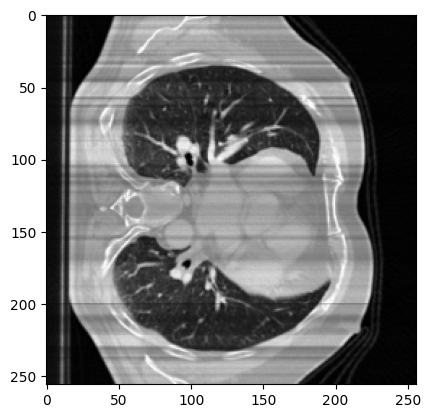

In [14]:
plt.imshow(sample_data[1].squeeze(0).numpy(), cmap='gray')

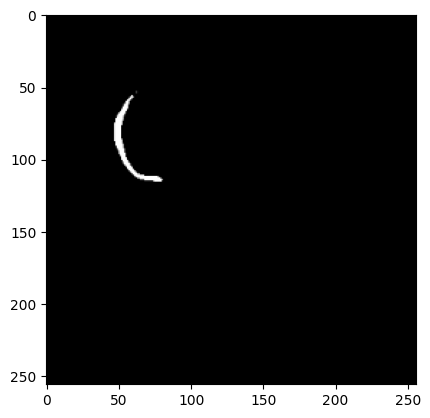

In [15]:
plt.imshow(sample_label[1].squeeze(0).numpy(), cmap='gray')

In [16]:
# Кастомный датасет без аугментации для тестирования данных 
class DICOM_seg_test(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_layers = []
        self.mask_layers = []
        self.images = os.listdir(image_dir)
        for image_file in self.images:
            img_path = os.path.join(self.image_dir, image_file)
            img_path = self.make_path_right(img_path)
            mask_path = os.path.join(self.mask_dir, image_file)
            mask_path = os.path.join(mask_path, os.listdir(mask_path)[0])
            mask_path = self.make_path_right(mask_path)

            image = self.load_dicom(img_path)
            self.image_layers.extend(image)
            
            mask = nib.load(mask_path).get_fdata().transpose(2,0,1)
            mask = scipy.ndimage.rotate(mask, 90,(1,2)).astype(np.float32)
            self.mask_layers.extend(mask)
        
    def __len__(self):
        return len(self.image_layers)
    
    @staticmethod
    def load_dicom(directory):
        reader = sitk.ImageSeriesReader()
        dicom_names = reader.GetGDCMSeriesFileNames(directory)
        reader.SetFileNames(dicom_names)
        image_itk = reader.Execute()
        image_zyx = sitk.GetArrayFromImage(image_itk).astype(np.int16)
        return image_zyx
    
    @staticmethod
    def make_path_right(path):
        path = path.replace('\\','/')
        return path
    
    def apply_transform(self, image, mask):
        
        # Transform to tensor
        image = transforms.functional.to_tensor(image)
        mask = transforms.functional.to_tensor(mask)

        
        # Center crop
        crop_transform = transforms.CenterCrop(size=(320, 320))
        image = crop_transform(image)
        mask = crop_transform(mask)
       
            
        # Resize
        resize = transforms.Resize(size=(256, 256), antialias=None)
        image = resize(image)
        mask = resize(mask)

    
        return image, mask
    
    def __getitem__(self, idx):
        # get one layer from images and masks
        image_layer = self.image_layers[idx]
 
        mask_layer = self.mask_layers[idx]
        
        scaler = MinMaxScaler()
        image_layer = scaler.fit_transform(image_layer)
        image_layer, mask_layer = self.apply_transform(image_layer, mask_layer)
        

        return image_layer, mask_layer#image_tensor, mask_tensor 

In [17]:
test_dataset = DICOM_seg_test('./test_subset','./test_subset_masks')

In [18]:
valid_loader = DataLoader(test_dataset, batch_size=2)

In [19]:
len(valid_loader.dataset)

245

### Загрузка модели

In [20]:
from torchvision import transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
device

device(type='cuda')

In [24]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in C:\Users\dany/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


In [60]:
# Нам нужно это делать как с моделью, так и с данными, которые будут в нее загружаться, чтобы избежать ошибок 
model = model.float()

In [1596]:
# Замена выходных слоев с целью того, чтобы модель предсказывала 1 класс, а не 21, как это было в предобученной модели

model.encoder1.enc1conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [71]:
# Замена первого слоя, чтобы модель принимала не RGB изображение, а наш одноканальный скан МРТ
# model.backbone['0'] = torchvision.ops.Conv2dNormActivation(1, 16,kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False )

In [7]:
# Данный иетратор дает нам имена для доступа к слоям модели для их замена 
for name, child in model.named_children():
        for x, y in child.named_children():
            print(name,x)

encoder1 enc1conv1
encoder1 enc1norm1
encoder1 enc1relu1
encoder1 enc1conv2
encoder1 enc1norm2
encoder1 enc1relu2
encoder2 enc2conv1
encoder2 enc2norm1
encoder2 enc2relu1
encoder2 enc2conv2
encoder2 enc2norm2
encoder2 enc2relu2
encoder3 enc3conv1
encoder3 enc3norm1
encoder3 enc3relu1
encoder3 enc3conv2
encoder3 enc3norm2
encoder3 enc3relu2
encoder4 enc4conv1
encoder4 enc4norm1
encoder4 enc4relu1
encoder4 enc4conv2
encoder4 enc4norm2
encoder4 enc4relu2
bottleneck bottleneckconv1
bottleneck bottlenecknorm1
bottleneck bottleneckrelu1
bottleneck bottleneckconv2
bottleneck bottlenecknorm2
bottleneck bottleneckrelu2
decoder4 dec4conv1
decoder4 dec4norm1
decoder4 dec4relu1
decoder4 dec4conv2
decoder4 dec4norm2
decoder4 dec4relu2
decoder3 dec3conv1
decoder3 dec3norm1
decoder3 dec3relu1
decoder3 dec3conv2
decoder3 dec3norm2
decoder3 dec3relu2
decoder2 dec2conv1
decoder2 dec2norm1
decoder2 dec2relu1
decoder2 dec2conv2
decoder2 dec2norm2
decoder2 dec2relu2
decoder1 dec1conv1
decoder1 dec1norm1
de

In [ ]:
model.eval()

In [53]:
# Проверка работы необученной модели
sample_data= sample_data.float()
output = model(sample_data.to(device))
# output = model(sample_data)

In [54]:
output.shape

torch.Size([2, 1, 256, 256])

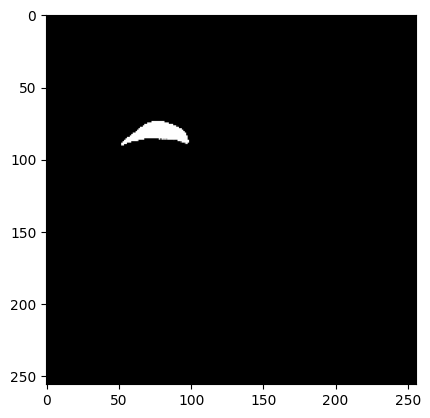

In [55]:
plt.imshow(output[1].detach().cpu().numpy().squeeze(0), cmap='gray')

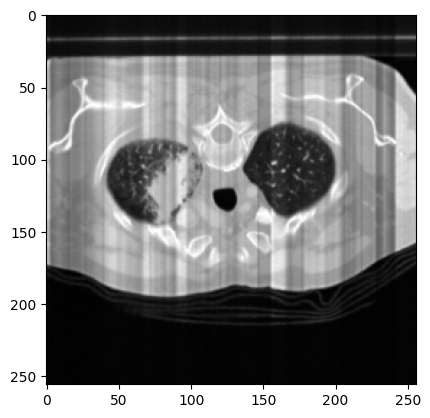

In [56]:
plt.imshow(sample_data[1].squeeze(0).numpy(), cmap='gray')

### Обучение модели

In [27]:

for param in list(model.parameters())[:]:
    param.requires_grad = True

In [28]:
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

In [29]:
optimizer = torch.optim.Adam(params_to_update)
criterion = nn.BCEWithLogitsLoss()

In [30]:
def dice_loss(input, target, smooth=1e-5):
    intersection = (input * target).sum()
    target_sum = target.sum()
    input_sum = input.sum()
    loss = 1 - (2 * intersection + smooth) / (target_sum + input_sum + smooth)
    return loss

In [31]:
def iou_metric(input, target):
    eps = 1e-6
    input = torch.sigmoid(input)
    intersection = (input * target).sum()
    union = input.sum() + target.sum() - intersection + eps
    iou = intersection / union
    return iou

In [32]:
def dice_coefficient(pred, target):
    smooth = 1e-6  # to prevent division by zero
    
    intersection = (pred * target).sum()
    dice = (2 * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    
    return dice

In [68]:
# model.float()

In [33]:
def train_model(model, optimizer, train_loader, valid_loader, device, criterion=dice_loss, metric=iou_metric, num_epochs=5):
    train_losses = []
    valid_losses = []
    train_metrics = []
    valid_metrics = []
    train_grads = []

    model.to(device)
    model.train()
    
    for epoch in range(num_epochs):
        train_loss, valid_loss, train_metric, valid_metric = 0.0, 0.0, 0.0,0.0    
        for batch_idx, data in enumerate(train_loader):
            inputs, target = data[0].to(device).to(torch.float), data[1].to(device).to(torch.float)
            
            optimizer.zero_grad()
            
            output = model(inputs)
            loss = criterion(output, target)
            
            loss.backward()
            
            if batch_idx%10==0:
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        grad_mean = param.grad.abs().mean().item()
                        train_grads.append((name, grad_mean))
            
            optimizer.step()
            
            train_loss += loss.item() 
            preds = torch.sigmoid(output) > 0.5
            train_metric += metric(preds.float(), target.float()) 
        
            
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        train_metric /= len(train_loader)
        train_metrics.append(train_metric)
        
        model.eval()
        
        for data in valid_loader:
            inputs, target = data[0].to(device).to(torch.float), data[1].to(device).to(torch.float)
            
            output = model(inputs)
            loss = criterion(output, target)
            
            valid_loss += loss.item()
            preds = torch.sigmoid(output) > 0.5
            valid_metric += metric(preds.float(), target.float()) 
            
        
        valid_loss /= len(valid_loader)
        valid_losses.append(valid_loss)
        valid_metric/= len(valid_loader)
        valid_metrics.append(valid_metric)
        
        model.train()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train {metric.__name__.upper()}: {train_metric:.4f}, Valid Loss: {valid_loss:.4f}, Valid {metric.__name__.upper()}: {valid_metric:.4f}')
    
    return train_losses, valid_losses, train_metrics, valid_metrics, train_grads  

In [44]:
%%time
train_losses, valid_losses, train_metrics, valid_metrics, train_grads = train_model(model, optimizer, train_loader, valid_loader, device, num_epochs=5, metric=dice_coefficient)

Epoch 1/5, Train Loss: 0.1151, Train DICE_COEFFICIENT: 0.8799, Valid Loss: 0.4600, Valid DICE_COEFFICIENT: 0.4830
Epoch 2/5, Train Loss: 0.1153, Train DICE_COEFFICIENT: 0.8794, Valid Loss: 0.4623, Valid DICE_COEFFICIENT: 0.5401
Epoch 3/5, Train Loss: 0.1151, Train DICE_COEFFICIENT: 0.8799, Valid Loss: 0.4878, Valid DICE_COEFFICIENT: 0.4767
Epoch 4/5, Train Loss: 0.1146, Train DICE_COEFFICIENT: 0.8797, Valid Loss: 0.4678, Valid DICE_COEFFICIENT: 0.4533
Epoch 5/5, Train Loss: 0.1171, Train DICE_COEFFICIENT: 0.8780, Valid Loss: 0.4762, Valid DICE_COEFFICIENT: 0.4467
CPU times: total: 2min 41s
Wall time: 2min 49s


### Проверка модели

In [45]:
train_iterator = iter(valid_loader)
for i in range(30):
    sample_data, sample_label = next(train_iterator)

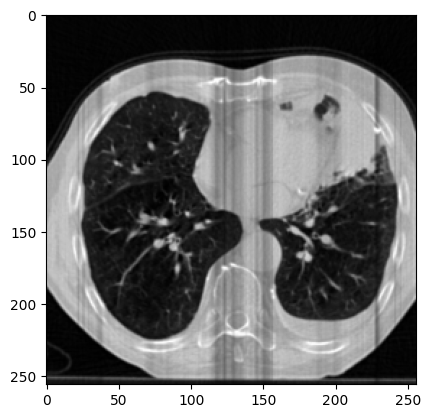

In [46]:
plt.imshow(sample_data[1].squeeze(0).numpy(), cmap='gray')

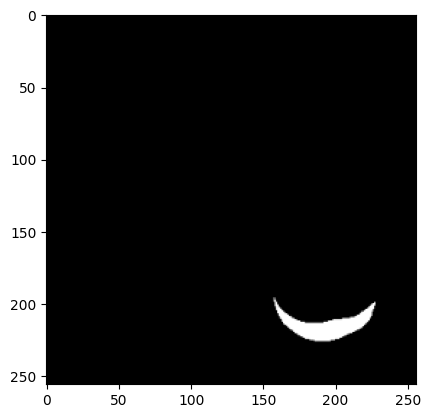

In [47]:
plt.imshow(sample_label[1].squeeze(0).numpy(), cmap='gray')

In [48]:
sample_data= sample_data.float()
output = model(sample_data.to(device))

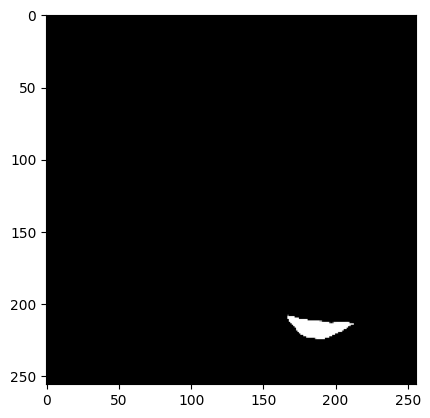

In [49]:
plt.imshow(output[1].detach().cpu().numpy().squeeze(0), cmap='gray')

In [76]:
PATH = "u-net_2d_256.pth"

# save the entire model
torch.save(model, PATH)

### Инференс

In [50]:
import napari

In [35]:
model = torch.load('u-net_2d_256.pth')

In [51]:
def load_dicom(directory):
        reader = sitk.ImageSeriesReader()
        dicom_names = reader.GetGDCMSeriesFileNames(directory)
        reader.SetFileNames(dicom_names)
        image_itk = reader.Execute()
        image_zyx = sitk.GetArrayFromImage(image_itk).astype(np.int16)
        return image_zyx
    
def predict_segment(DICOM_directory, model, vizualize=False):
    model.eval()
    image = load_dicom(DICOM_directory)
    scaler = MinMaxScaler()
    
    image = torch.Tensor(image)
    
    i=0
    for s in image:
        image[i] = torch.Tensor(scaler.fit_transform(s))
        i+=1
        
    crop_transform = transforms.CenterCrop(size=(320, 320))
    image = crop_transform(image)
  
    resize = transforms.Resize(size=(256, 256), antialias=None)
    image = resize(image)
    image =  image.unsqueeze(1)
    shape_of_file = image.shape[0]
    result = np.zeros((shape_of_file, 1, 256, 256))
  
    
    i=0
    for m in image:
        m = m.unsqueeze(0)
        m = m.float()
        output = model(m.to(device))
        result[i] = output.detach().cpu().numpy()
        i+=1
       
    if vizualize:
        image = image.detach().cpu().numpy()
        viewer = napari.Viewer()
        viewer.add_image(image.squeeze(1), name='DICOM')
        viewer.add_labels(result.squeeze(1).astype(int), name='Mask')
       
  
    return image, result
    
    
        

In [56]:
%%time
image, result = predict_segment('./test_subset/LUNG1-002', model=model, vizualize=True)

CPU times: total: 2.05 s
Wall time: 1.63 s
